# Housing Renovation Analysis

<img src="images/housing.jpg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Overview
This project uses linear regression analysis to infer how certain variables impact housing prices and by how much. Analysis of data from King County House Sales shows that house condition, grade, and bathroom number are three key features that can increase a house's price. Any home seller can use this information to make decisions on potential renovations. 

## Business Problem
A real estate agency is looking to guide homeowners who looking to sell their houses. They want to provied these homeowners with anlaysis of how renovations may impact the price of their home.

## Data Understanding
This project uses data from the King County House Sales dataset. It includes information on house age, size, condition and other features.

In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [420]:
df = pd.read_csv('data/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [422]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

## Data Preparation

### Data Cleaning
Drop irrelevant columns, address missing values and manipulate data into desired forms

In [423]:
#drop irrelevant columns
df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'yr_renovated', 'view'], axis=1, inplace=True)

In [424]:
#fill in missing sqft_basement values
df.loc[df.sqft_basement == '?', 'sqft_basement'] = (df[df.sqft_basement == '?'].sqft_living
                               - df[df.sqft_basement == '?'].sqft_above)

#convert into numeric
df['sqft_basement'] = df.sqft_basement.astype('float64')

#convert into categorical variable
df['is_basement'] = df.sqft_basement.map(lambda x: 0 if x == 0 else 1)
df.drop('sqft_basement', axis=1, inplace=True)

In [425]:
#convert condition and grade into numeric values
df['condition'] = df.condition.map(lambda x: 0 if x=='Poor' 
                                   else (1 if x=='Fair'
                                    else (2 if x=='Average'
                                    else  (3 if x=='Good' else 4))))

df['grade'] = df.grade.map(lambda x: int(x[0:2])-3)

In [426]:
df.waterfront.isna().sum()

2376

In [427]:
categoricals = ['waterfront']

In [428]:
dummies = pd.get_dummies(df[categoricals], prefix=categoricals, drop_first=True)

In [429]:
df.drop(categoricals, axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

### Transformation and Scaling

In [430]:
#continuous variables
cont_data = df.loc[:, ((df.dtypes != 'object') & (df.nunique() > 20))]

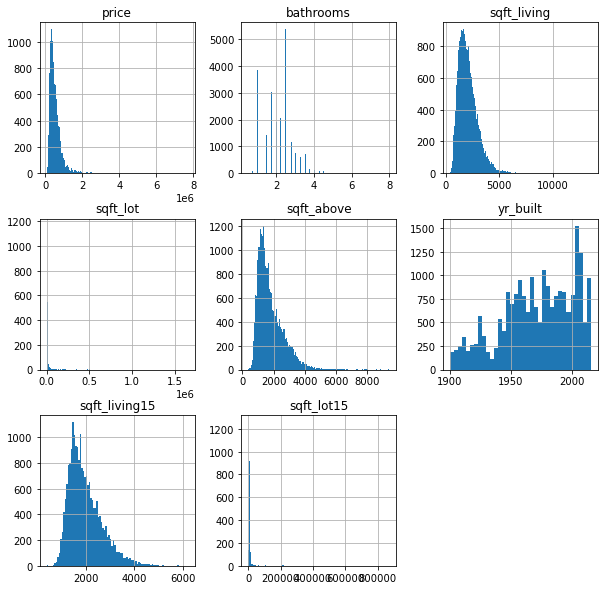

In [431]:
cont_data.hist(bins='auto', figsize=(10,10));

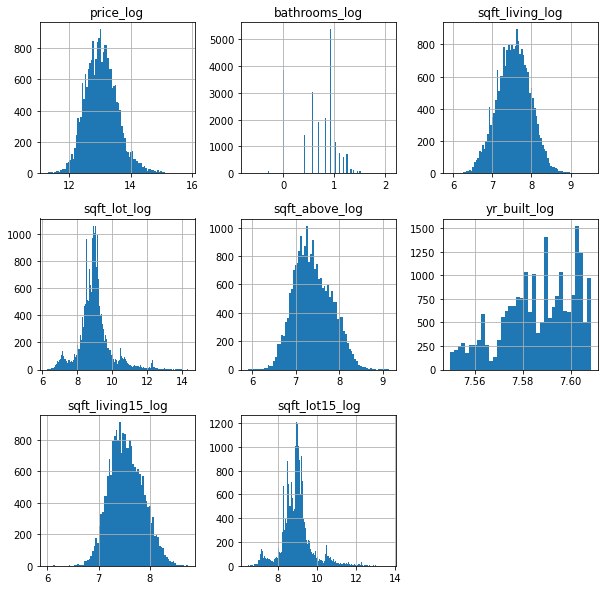

In [432]:
#log transforms of continuous variables
log_names = [f'{column}_log' for column in cont_data.columns]

cont_log = np.log(cont_data);
cont_log.columns = log_names;
cont_log.hist(figsize=(10, 10), bins='auto');

In [433]:
#replace continuous variables with log transforms
df.drop(cont_data.columns, axis=1, inplace=True)
data = pd.concat([df,cont_log],  axis=1)

In [471]:
#feature scaling
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(data.drop('waterfront_YES', axis=1))
data_std = std_scale.transform(data.drop('waterfront_YES', axis=1))
data_std = pd.DataFrame(data_std, columns=data.drop('waterfront_YES', axis=1).columns)

In [472]:
final_data = pd.concat([data_std,data.waterfront_YES],  axis=1)

## Modeling

In [473]:
X = final_data.drop('price_log', axis=1)
y = final_data.price_log

In [474]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [153]:
features = ['condition', 'bathrooms','grade']

In [475]:
import statsmodels.api as sm

model = sm.OLS(y_train, sm.add_constant(X_train.drop('sqft_lot_log', axis=1))).fit()

C:\Users\bento\anaconda3.0\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [476]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     2628.
Date:                Sun, 16 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:16:30   Log-Likelihood:                -14257.
No. Observations:               16197   AIC:                         2.854e+04
Df Residuals:                   16184   BIC:                         2.864e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0045      0.005     -0.973      0.330      -0.014       0.005
bedrooms             -0.0597      0.006     -9.434      0.000      -0.072      -0.047
floors                0.0780      0.007     11.137      0.000       0.064       0.092
condition             0.0515      0.005     10.208      0.000       0.042       0.061
grade                 0.4799      0.008     60.725      0.000       0.464       0.495
is_basement           0.0885      0.010      9.083      0.000       0.069       0.108
bathrooms_log         0.0742      0.008      8.874      0.000       0.058       0.091
sqft_living_log       0.2071      0.021     10.044      0.000       0.167       0.248
sqft_above_log        0.0578      0.020      2.855      0.004       0.018       0.098
yr_built_log         -0.3224      0.006    -52.123      0.000      -0.334      -0.310
sqft_living15_log     0.1739      0.008     23.068      0.000       0.159       0.189
sqft_lot15_log       -0.0875      0.006    -15.338      0.000      -0.099      -0.076
waterfront_YES        1.0753      0.055     19.448      0.000       0.967       1.184
==============================================================================
Omnibus:                       53.719   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.363
Skew:                          -0.027   Prob(JB):                     5.26e-16
Kurtosis:                       3.318   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [463]:
X_train_final = X_train
X_test_final = X_test

In [464]:
final_model = LinearRegression()

In [465]:
final_model.fit(X_train_final, y_train)

LinearRegression()

In [466]:
final_model.score(X_test_final, y_test)

0.6682532071359475

## Check for Linear Regression Assumptions

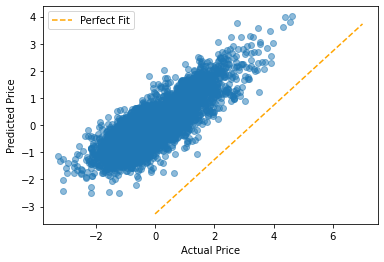

In [469]:
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

C:\Users\bento\anaconda3.0\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


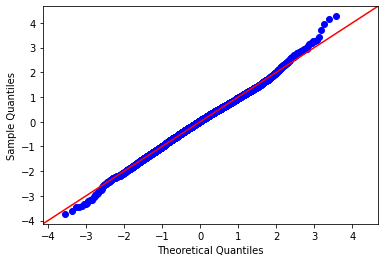

In [459]:
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

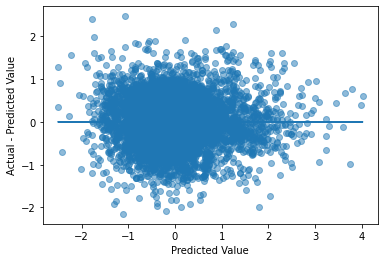

In [460]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

In [392]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

bedrooms               27.050650
floors                 20.441041
condition              16.249926
grade                  48.894828
is_basement             7.224768
waterfront_YES          1.023098
bathrooms_log          11.261585
sqft_living_log      6284.783146
sqft_lot_log          673.558774
sqft_above_log       5779.326369
yr_built_log         1333.295593
sqft_living15_log    1469.279214
sqft_lot15_log        796.056021
Name: Variance Inflation Factor, dtype: float64

## Baseline Model

In [247]:
baseline_model = LinearRegression()

In [252]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=df[['sqft_living']],
    y=df[['price']],
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.48774659364870426
Validation score: 0.5024006604207555


In [253]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.686751031368749
Validation score: 0.6755513899110218


In [254]:
import statsmodels.api as sm

sm.OLS(y_train, sm.add_constant(X_train)).fit().summary()

C:\Users\bento\anaconda3.0\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     1254.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:36:28   Log-Likelihood:            -2.2110e+05
No. Observations:               16197   AIC:                         4.423e+05
Df Residuals:                   16168   BIC:                         4.425e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.927e+06   1.48e+05     46.851      0.000    6.64e+06    7.22e+06
bedrooms            -2.493e+04   2258.793    -11.038      0.000   -2.94e+04   -2.05e+04
bathrooms            4.873e+04   3861.605     12.619      0.000    4.12e+04    5.63e+04
sqft_living           129.9518      7.299     17.803      0.000     115.644     144.260
sqft_lot                0.0312      0.058      0.534      0.593      -0.083       0.146
floors               4.458e+04   4235.616     10.524      0.000    3.63e+04    5.29e+04
sqft_above            -10.2653      8.038     -1.277      0.202     -26.020       5.489
yr_built            -3258.0794     75.607    -43.092      0.000   -3406.277   -3109.882
sqft_living15          26.2740      4.002      6.565      0.000      18.429      34.119
sqft_lot15             -0.6266      0.086     -7.322      0.000      -0.794      -0.459
waterfront_YES       5.438e+05   2.39e+04     22.732      0.000    4.97e+05    5.91e+05
view_EXCELLENT       1.763e+05   1.82e+04      9.681      0.000    1.41e+05    2.12e+05
view_FAIR            5.957e+04   1.49e+04      3.999      0.000    3.04e+04    8.88e+04
view_GOOD            6.513e+04    1.3e+04      5.021      0.000    3.97e+04    9.05e+04
view_NONE           -5.448e+04   7882.277     -6.912      0.000   -6.99e+04    -3.9e+04
condition_Fair      -2.371e+04   1.86e+04     -1.278      0.201   -6.01e+04    1.27e+04
condition_Good       1.713e+04   4025.555      4.254      0.000    9235.115     2.5e+04
condition_Poor      -9.435e+04   4.33e+04     -2.181      0.029   -1.79e+05   -9538.110
condition_Very Good  5.393e+04   6480.361      8.322      0.000    4.12e+04    6.66e+04
grade_11 Excellent   2.939e+05   1.41e+04     20.912      0.000    2.66e+05    3.21e+05
grade_12 Luxury      7.262e+05   2.71e+04     26.827      0.000    6.73e+05    7.79e+05
grade_13 Mansion     1.784e+06    7.4e+04     24.102      0.000    1.64e+06    1.93e+06
grade_3 Poor        -3.257e-10   1.51e-10     -2.160      0.031   -6.21e-10   -3.02e-11
grade_4 Low          -5.06e+05   4.86e+04    -10.406      0.000   -6.01e+05   -4.11e+05
grade_5 Fair        -5.399e+05   1.93e+04    -28.006      0.000   -5.78e+05   -5.02e+05
grade_6 Low Average -4.828e+05   1.21e+04    -39.831      0.000   -5.07e+05   -4.59e+05
grade_7 Average     -4.053e+05      1e+04    -40.497      0.000   -4.25e+05   -3.86e+05
grade_8 Good        -3.223e+05   9045.232    -35.635      0.000    -3.4e+05   -3.05e+05
grade_9 Better      -1.803e+05   8817.135    -20.446      0.000   -1.98e+05   -1.63e+05
is_basement          2.068e+04   6180.257      3.346      0.001    8566.717    3.28e+04
==============================================================================
Omnibus:                     9858.717   Durbin-Watson:                   2.006
Prob(Omnibus):       

In [117]:
significant_features = ["bedrooms", "bathrooms", "floors", "waterfront", "condition",
                       "grade", "yr_built", "sqft_above",
                       "sqft_living", "sqft_living15", "sqft_lot15"]

In [118]:
# significant_features = ["bedrooms", "floors", "waterfront", "condition",
#                         "yr_built", "sqft_living", "sqft_lot15"]

In [120]:
from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[significant_features],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.6466812437493469
Validation score: 0.6604438919448264


In [255]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
data_for_RFECV = StandardScaler().fit_transform(X_train)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(data_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: False
floors: True
sqft_above: True
yr_built: True
sqft_living15: True
sqft_lot15: True
waterfront_YES: True
view_EXCELLENT: True
view_FAIR: False
view_GOOD: False
view_NONE: True
condition_Fair: False
condition_Good: False
condition_Poor: False
condition_Very Good: True
grade_11 Excellent: True
grade_12 Luxury: True
grade_13 Mansion: True
grade_3 Poor: False
grade_4 Low: True
grade_5 Fair: True
grade_6 Low Average: True
grade_7 Average: True
grade_8 Good: True
grade_9 Better: True
is_basement: False


In [260]:
features = X_train.columns[selector.support_]

In [261]:
sm.OLS(y_train, sm.add_constant(X_train[features])).fit().summary()

C:\Users\bento\anaconda3.0\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1663.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:42:15   Log-Likelihood:            -2.2113e+05
No. Observations:               16197   AIC:                         4.423e+05
Df Residuals:                   16175   BIC:                         4.425e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                7.126e+06   1.44e+05     49.540      0.000    6.84e+06    7.41e+06
bedrooms            -2.487e+04   2259.183    -11.008      0.000   -2.93e+04   -2.04e+04
bathrooms            5.029e+04   3841.079     13.092      0.000    4.28e+04    5.78e+04
sqft_living           149.1278      5.133     29.050      0.000     139.066     159.190
floors               4.224e+04   4201.153     10.054      0.000     3.4e+04    5.05e+04
sqft_above            -32.6430      5.090     -6.413      0.000     -42.620     -22.666
yr_built            -3337.6453     73.912    -45.157      0.000   -3482.522   -3192.769
sqft_living15          26.7186      3.999      6.682      0.000      18.881      34.557
sqft_lot15             -0.5913      0.061     -9.720      0.000      -0.711      -0.472
waterfront_YES       5.446e+05    2.4e+04     22.736      0.000    4.98e+05    5.92e+05
view_EXCELLENT       1.445e+05   1.74e+04      8.285      0.000     1.1e+05    1.79e+05
view_NONE           -8.245e+04   6167.795    -13.367      0.000   -9.45e+04   -7.04e+04
condition_Very Good  4.587e+04   6239.830      7.351      0.000    3.36e+04    5.81e+04
grade_11 Excellent   2.951e+05   1.41e+04     20.964      0.000    2.67e+05    3.23e+05
grade_12 Luxury      7.241e+05   2.71e+04     26.703      0.000    6.71e+05    7.77e+05
grade_13 Mansion      1.78e+06   7.41e+04     24.005      0.000    1.63e+06    1.93e+06
grade_4 Low         -5.143e+05   4.86e+04    -10.578      0.000    -6.1e+05   -4.19e+05
grade_5 Fair        -5.505e+05   1.91e+04    -28.801      0.000   -5.88e+05   -5.13e+05
grade_6 Low Average  -4.88e+05   1.21e+04    -40.428      0.000   -5.12e+05   -4.64e+05
grade_7 Average     -4.066e+05      1e+04    -40.654      0.000   -4.26e+05   -3.87e+05
grade_8 Good         -3.23e+05   9044.095    -35.709      0.000   -3.41e+05   -3.05e+05
grade_9 Better      -1.806e+05   8825.919    -20.458      0.000   -1.98e+05   -1.63e+05
==============================================================================
Omnibus:                     9756.783   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           419792.946
Skew:                           2.263   Prob(JB):                         0.00
Kurtosis:                      27.526   Cond. No.                     2.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()


In [297]:
cont_log_norm = cont_log.apply(normalize)

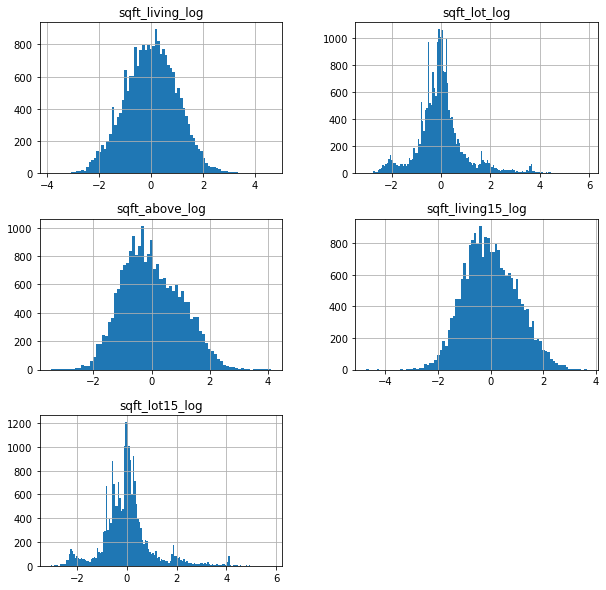

In [332]:
cont_log_norm.hist(figsize=(10, 10), bins='auto');

In [301]:
data_norm = data.drop('price', axis=1).apply(normalize)

In [303]:
final_data = pd.concat([df[['price']], data_norm], axis=1)

In [344]:
df2=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df2['pairs'] = list(zip(df2.level_0, df2.level_1))

# set index to pairs
df2.set_index(['pairs'], inplace = True)

#d rop level columns
df2.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df2.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df2.drop_duplicates(inplace=True)

In [346]:
df2[(df2.cc>.75) & (df2.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living, bathrooms)",0.755758


## Assumptions

In [127]:
X_train_final = X_train[significant_features]
X_test_final = X_test[significant_features]

In [128]:
final_model = LinearRegression()

In [129]:
final_model.fit(X_train_final, y_train)

LinearRegression()

In [130]:
final_model.score(X_test_final, y_test)

0.6404700884222043

In [131]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, final_model.predict(X_test_final), squared=False)

217661.07009109753

In [132]:
print(pd.Series(final_model.coef_, index=X_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

bedrooms         -47811.652319
bathrooms         51581.343942
floors            28004.853595
waterfront       785531.273479
condition         21136.655537
grade            123262.867436
yr_built          -3815.696253
sqft_above          -15.875420
sqft_living         184.146258
sqft_living15        27.813219
sqft_lot15           -0.609609
Name: Coefficients, dtype: float64

Intercept: 6669204.745548959


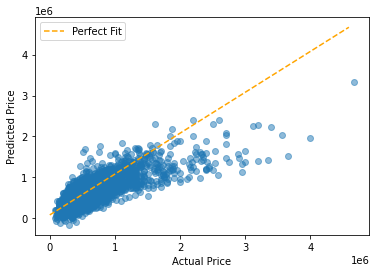

In [133]:
preds = final_model.predict(X_test_final)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
ax.scatter(y_test, preds, alpha=0.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price")
ax.legend();

C:\Users\bento\anaconda3.0\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


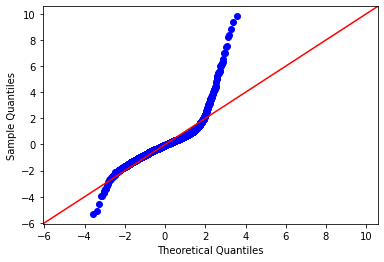

In [134]:
import scipy.stats as stats
residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

In [135]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

bedrooms          25.057103
bathrooms         25.783512
sqft_living      103.019577
sqft_lot           2.216549
floors            16.455424
waterfront         1.026952
condition         15.863944
grade            141.955142
sqft_above        94.408154
yr_built         110.751149
sqft_living15     26.015759
sqft_lot15         2.455143
is_basement        5.698332
Name: Variance Inflation Factor, dtype: float64

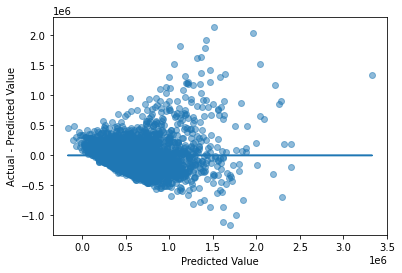

In [136]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");